In [1]:
import pandas as pd
from google.cloud import bigquery
from google.oauth2 import service_account
import warnings
warnings.filterwarnings("ignore")
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
from tqdm import tqdm

## Import data

In [2]:
credentials = service_account.Credentials.from_service_account_file('bigquery-production.json')
project_id = 'production-247608'
client = bigquery.Client(credentials= credentials,project=project_id)

query_job = client.query("""
    SELECT user_pseudo_id, session_id, timestamp_local, event_name, clean_path
    FROM `production-247608.dataform.ga4_raw_flat_nl` 
    WHERE date >= '2024-04-16' """)
raw_data = query_job.result().to_dataframe()

## Preprocessing

In [3]:
events = ['showrooms_info_view', 'showroom_appointment_step', 'category_banner_view', 'inspiratie_view',
          'advies_view', 'mijnsanitair_view', 'view_item_list', 'view_item', 'add_to_cart', 
          'remove_from_cart', 'begin_checkout', 'view_cart', 'add_to_wishlist', 'view_search_results',
          'product_compare']

In [4]:
data_cleaned = raw_data[raw_data['event_name'].isin(events)]

In [5]:
data_cleaned = data_cleaned.sort_values(['session_id','timestamp_local']).reset_index(drop=True)
# drop row if the previous row has the same session_id, event_name and clean_path 
mask = (data_cleaned['session_id'] == data_cleaned['session_id'].shift(1)) & \
        (data_cleaned['event_name'] == data_cleaned['event_name'].shift(1)) & \
        (data_cleaned['clean_path'] == data_cleaned['clean_path'].shift(1))
data_cleaned = data_cleaned[~mask]

### Minimum session time

In [6]:
session_start_time = data_cleaned.groupby('session_id')['timestamp_local'].min()
session_end_time = data_cleaned.groupby('session_id')['timestamp_local'].max()
session_length = pd.merge(session_start_time, session_end_time, on='session_id', how='left', suffixes=(' start', ' end'))
session_length['session_length'] = session_length['timestamp_local end']-session_length['timestamp_local start']
minimum_30_seconds = session_length[session_length['session_length'] > '0 days 00:00:30']
data = data_cleaned[data_cleaned['session_id'].isin(minimum_30_seconds.index)]
data = data.sort_values(by=['session_id','timestamp_local']).reset_index(drop=True)

### Add variables

In [7]:
data_sorted = data.sort_values(['session_id','timestamp_local']).reset_index(drop=True)
# create a column with the time between the consecutive events if the session ids are the same otherwise the time is pd.NaT
data_sorted['time_between_events'] = data_sorted['timestamp_local'].diff().where(data_sorted['session_id'].eq(data_sorted['session_id'].shift())).fillna(pd.Timedelta(seconds=0))

In [8]:
# create a column with the time between the current event and the start of the session
data_sorted = data_sorted.sort_values(['session_id','timestamp_local']).reset_index(drop=True)
data_sorted['time_since_session_start'] = data_sorted['timestamp_local'] - data_sorted.groupby('session_id')['timestamp_local'].transform('first')

In [9]:
data_sorted = data_sorted.sort_values(['session_id','timestamp_local']).reset_index(drop=True)
data_sorted['number of events'] =  data_sorted.groupby('session_id').cumcount() + 1
data_sorted['total number of events'] = data_sorted.groupby('session_id')['number of events'].transform('max')

In [11]:
data_min_events = data_sorted[(data_sorted['total number of events'] >= 5) & (data_sorted['total number of events'] <= 50)]
#data_min_events.to_csv('../../data/sessionmodel 20240403.csv', index=False)

## ML preprocessing

### Create decision points

In [12]:
incoming_arcs = {}
outgoing_arcs = {}
for event in events:
    incoming_arcs[event] = {}
    outgoing_arcs[event] = {}
    for event2 in events:
        incoming_arcs[event][event2] = 0
        outgoing_arcs[event][event2] = 0
for user in data_min_events['session_id'].unique():
    user_data = data_min_events[data_min_events['session_id'] == user]
    for i in range(len(user_data)-1):
        event1 = user_data['event_name'].iloc[i]
        event2 = user_data['event_name'].iloc[i+1]
        incoming_arcs[event2][event1] += 1
        outgoing_arcs[event1][event2] += 1

### Tokenize and pad sequences

In [13]:
data_ml = data_min_events.sort_values(['session_id','timestamp_local']).reset_index(drop=True)

if 'event_list' not in data_ml:
    data_ml['event_list'] = [[] for _ in range(len(data_ml))]
if 'tsst_list' not in data_ml:
    data_ml['tsst_list'] = [[] for _ in range(len(data_ml))]
if 'tbe_list' not in data_ml:
    data_ml['tbe_list'] = [[] for _ in range(len(data_ml))]
if 'prefix_id' not in data_ml:
    data_ml['prefix_id'] = [None for _ in range(len(data_ml))]

users = data_ml['session_id'].unique()
for user in tqdm(users):
    user_data = data_ml[data_ml['session_id'] == user]
    prefix_extension = 0
    event_list = []
    tsst_list = []
    tbe_list = []
    for idx in user_data.index:
        data_ml.at[idx, 'prefix_id'] = f'{user}_{prefix_extension}'
        prefix_extension += 1

        event_list.append(data_ml.at[idx, 'event_name'])
        data_ml.at[idx, 'event_list'] = event_list.copy()
        
        tsst_list.append(data_ml.at[idx, 'time_since_session_start'])
        data_ml.at[idx, 'tsst_list'] = tsst_list.copy()

        tbe_list.append(data_ml.at[idx, 'time_between_events'])
        data_ml.at[idx, 'tbe_list'] = tbe_list.copy()

100%|██████████| 157261/157261 [11:29<00:00, 228.06it/s]


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Tokenize the event_list to numbers = integer tokenization
tokenizer.fit_on_texts(data_ml['event_list'])
data_ml['tokenized_event_list'] = tokenizer.texts_to_sequences(data_ml['event_list'])

# Pre-Pad the tokenized text with 0's
data_ml['tokenized_event_list'] = list(pad_sequences(data_ml['tokenized_event_list']))
data_ml['tbe_list'] = data_ml['tbe_list'].apply(lambda x: [y.total_seconds() for y in x])
data_ml['tsst_list'] = data_ml['tsst_list'].apply(lambda x: [y.total_seconds() for y in x])

data_ml['tbe_list_padded'] = list(pad_sequences(data_ml['tbe_list'], value=-1))
data_ml['tsst_list_padded'] = list(pad_sequences(data_ml['tsst_list'], value=-1))

### Create target variable

In [15]:
decision_points = data_ml[((data_ml['event_name'] == 'showrooms_info_view') | (data_ml['event_name'] == 'showroom_appointment_step'))].index
data_ml['decision_point'] = 0
data_ml.loc[decision_points, 'decision_point'] = 1
showroom_users = data_ml[data_ml['decision_point'] == 1]['session_id'].unique()
data_ml['target'] = data_ml['session_id'].apply(lambda x: 1 if x in showroom_users else 0)

### Truncate the sessions at its first decision point

In [16]:
# based on the decision points, remove all prefixes from a session after the first decision point in that session
def truncate_after_decision(session_data):
    min_index = session_data.index[4]
    # Check if there's a decision point in this session
    if session_data['decision_point'].sum() > 0:
        # Get the index of the first decision point
        decision_index = session_data[session_data['decision_point']==1].index.min()
        # Return data up to and including the decision point
        return session_data.loc[min_index:decision_index-1]
    else:
        # Return the session data as is if there's no decision point
        return session_data.loc[min_index:]

In [17]:
# Group by session_id and apply the truncation
truncated_sessions = data_ml.groupby('session_id').apply(truncate_after_decision).reset_index(drop=True)

In [18]:
truncated_sessions['target'].value_counts()

target
0    997941
1     36981
Name: count, dtype: int64

### train test split

In [19]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

X = truncated_sessions[['tokenized_event_list', 'tbe_list_padded', 'tsst_list_padded']]
y = truncated_sessions['target']

X_flattened = np.array([np.concatenate([row[col] for col in X.columns]) for _, row in X.iterrows()])

X_train_flat, X_test_flat, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=123)

#smote = SMOTE(random_state=123)
#X_train_flat_oversampled, y_train = smote.fit_resample(X_train_flat, y_train)
target_0 = truncated_sessions['target'].value_counts()[0]
#ros = RandomOverSampler(sampling_strategy={0: target_0, 1: round(target_0*0.2)})
#X_train_flat_oversampled, y_train = ros.fit_resample(X_train_flat, y_train)
rus = RandomUnderSampler(random_state=42)
X_train_flat_oversampled, y_train = rus.fit_resample(X_train_flat, y_train)

In [20]:
y_train.value_counts()

target
0    29586
1    29586
Name: count, dtype: int64

### ML modelling

Random Forrest Classifier

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat_oversampled)
X_test_scaled = scaler.transform(X_test_flat)

# Handling class imbalance
smote = SMOTE(random_state=123)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=123), param_grid, cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best model
clf_best = grid_search.best_estimator_

# Make predictions and evaluate the model
y_pred = clf_best.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.51      0.67    199590
           1       0.04      0.57      0.08      7395

    accuracy                           0.51    206985
   macro avg       0.51      0.54      0.37    206985
weighted avg       0.94      0.51      0.65    206985



In [22]:
params = clf_best.get_params()
params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [35]:
y_pred = clf_best.predict(X_test_scaled)
auc_roc = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC: {auc_roc}")

AUC-ROC: 0.5395664103298172


LSTM Classifier

In [23]:
import tensorflow as tf

# Reshape the data back to its original structure for the LSTM
n_features = 3  # Assuming each original sample has 3 features
n_timesteps = 50  # Assuming each original sample has 50 time steps
X_train_oversampled = X_train_flat_oversampled.reshape(-1, n_timesteps, n_features)
X_test = X_test_flat.reshape(-1, n_timesteps, n_features)
print(X_train_oversampled.shape)
# Define the LSTM model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(50,3)),  # Adjust the number of units and input_shape based on your data
    tf.keras.layers.LSTM(16),#, return_sequences=True),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.LSTM(25),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Use 'sigmoid' for binary classification and 'softmax' for multi-class
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use 'binary_crossentrSopy' for binary classification and 'categorical_crossentropy' for multi-class
              metrics=[tf.keras.metrics.AUC()])

# Train the model
model.fit(X_train_oversampled, y_train, epochs=5, batch_size=128, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy}")

(59172, 50, 3)
Epoch 1/5
370/370 [==============================] - 18s 38ms/step - loss: 0.6604 - auc: 0.5226 - val_loss: 0.9238 - val_auc: 0.0000e+00
Epoch 2/5
370/370 [==============================] - 13s 36ms/step - loss: 0.6589 - auc: 0.5297 - val_loss: 0.9828 - val_auc: 0.0000e+00
Epoch 3/5
370/370 [==============================] - 13s 36ms/step - loss: 0.6583 - auc: 0.5323 - val_loss: 0.9068 - val_auc: 0.0000e+00
Epoch 4/5
370/370 [==============================] - 13s 36ms/step - loss: 0.6581 - auc: 0.5350 - val_loss: 0.9842 - val_auc: 0.0000e+00
Epoch 5/5
6469/6469 [==============================] - 46s 7ms/step - loss: 0.4864 - auc: 0.5401
Test accuracy: 0.5401233434677124


In [24]:
#model.save('../models/LSTM-10epoch-bs128')

In [25]:
y_prob = model.predict(X_test)

In [26]:
y_pred = (y_prob > 0.5).astype(int)
sum(y_pred)

array([18])

In [27]:
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC: {auc_roc}")

AUC-ROC: 0.5402353343624207


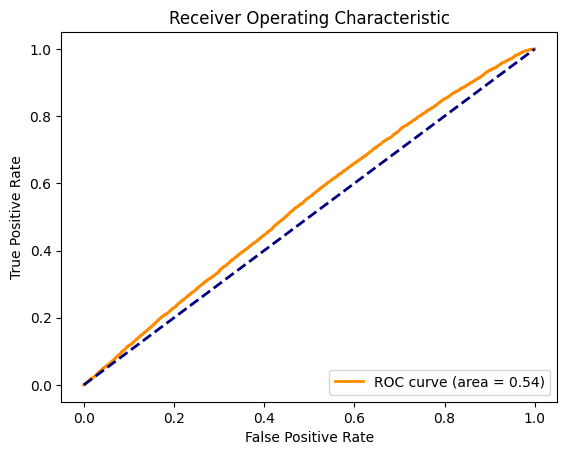

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### ULMFiT pre-trained model

In [29]:
def combine_features(row):
    # Combine all tokens into a single string
    events_str = ' '.join(row['event_list'])
    
    # Convert numerical features into string and concatenate them with a label for clarity
    session_start_str = ' '.join(['SESSION_START_' + str(ss) for ss in row['tsst_list']])
    between_activities_str = ' '.join(['BETWEEN_ACTIVITIES_' + str(ba) for ba in row['tbe_list']])
    
    # Combine everything into a single string
    return ' '.join([events_str, session_start_str, between_activities_str])

truncated_sessions['combined'] = truncated_sessions.apply(combine_features, axis=1)

In [30]:
df_pt = truncated_sessions[['combined', 'target']]

minority = df_pt[df_pt['target']==1]

minority_oversampled = minority.sample(n=222264, replace=True)

df_oversampled = pd.concat([df_pt, minority_oversampled])

In [31]:
from fastai.text.all import *

dls = TextDataLoaders.from_df(df_oversampled, text_col='combined', label_col='target', valid_pct=0.2, seed=42)

# Step 4: Train the ULMFiT Model
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy,time
0,0.257459,0.199483,0.943246,3:19:00


epoch,train_loss,valid_loss,accuracy,time
0,0.162445,0.238315,0.949832,9:47:52


In [32]:
test_df_pt = df_pt[:50000]
test_dls = TextDataLoaders.from_df(test_df_pt, text_col='combined', label_col='target', is_lm=False, valid_pct=0)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


In [33]:
import torch

# Switch to evaluation mode
learn.model.eval()

# Store predictions and actual labels
preds_pt = []
y_true_pt = []

# Iterate over the test set
for batch in test_dls.train:
    with torch.no_grad():
        outputs = learn.model(batch[0])
        preds_pt.append(outputs[0].softmax(dim=-1)[:,1])  # Probabilities for the positive class
        y_true_pt.append(batch[1])

# Concatenate all batches
preds_pt = torch.cat(preds_pt).cpu().numpy()
y_true_pt = torch.cat(y_true_pt).cpu().numpy()


In [34]:
from sklearn.metrics import roc_auc_score

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_true_pt, preds_pt)
print(f"AUC-ROC: {auc_roc:.4f}")

AUC-ROC: 0.5019
